In [1]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('../..'))))

import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from models.Feature.GooLeNet import GoogLeNet
from models.Feature.ResNet import ResNet18

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = 'cpu'
    torch.set_default_tensor_type('torch.FloatTensor')

# cifar10
class_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

model = ResNet18(classes=len(class_name)).to(device)

model.load_state_dict(torch.load('resnet18_model.pth'))

model = model.eval()

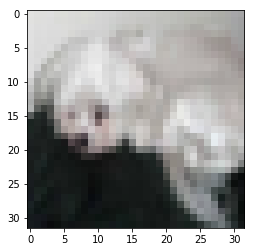

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = './test/test4.png'

img = Image.open(img_path)

plt.imshow(img)

In [4]:
import torchvision.transforms as transforms
from torch.autograd import Variable

cvt_tensor = transforms.Compose([transforms.Resize((128,128)),
                                 transforms.ToTensor()])

tensor_img = cvt_tensor(img).to(device)

tensor_img = tensor_img.view(1, 3, 128, 128)

In [5]:
gradients = []

def save_gradient(grad):
    gradients.append(grad)
    
datas = Variable(tensor_img)

feature = datas[0].unsqueeze(0)

In [6]:
for name,_ in model.named_children():
    print(name)

conv1
bn1
relu1
max_pool1
Block1
Block2
Block3
Block4
avg_pool2
dense1


In [7]:
for name, module in model.named_children():
    print(feature.shape)
    if name == 'dense1':
        feature = feature.view(feature.size(0), -1)
    feature = module(feature)
    if name == 'Block4':
        feature.register_hook(save_gradient)
        final_conv = feature

torch.Size([1, 3, 128, 128])
torch.Size([1, 64, 64, 64])
torch.Size([1, 64, 64, 64])
torch.Size([1, 64, 64, 64])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 128, 16, 16])
torch.Size([1, 256, 8, 8])
torch.Size([1, 512, 4, 4])
torch.Size([1, 512, 1, 1])


In [8]:
import torch.nn.functional as F

classes = torch.sigmoid(feature)
#classes = F.softmax(feature)

In [9]:
print(classes.data[0].sort(0, True))

torch.return_types.sort(
values=tensor([9.9986e-01, 1.1029e-06, 5.4337e-07, 5.0823e-07, 3.7248e-07, 1.4401e-07,
        3.4313e-08, 2.7823e-08, 9.2976e-09, 1.8043e-10]),
indices=tensor([5, 3, 6, 0, 9, 2, 1, 4, 8, 7]))


In [10]:
print(classes.data[0].max(dim=-1))

torch.return_types.max(
values=tensor(0.9999),
indices=tensor(5))


In [11]:
one_hot, _ = classes.max(dim=-1)

one_hot.backward()

In [12]:
final_conv = final_conv.squeeze(0)

weight = gradients[0].mean(dim=-1, keepdim=True).mean(dim=-2, keepdim=True)
weights = torch.mean(gradients[0], [0,2,3]).cpu().numpy()

activations = final_conv.detach().cpu().numpy()

In [13]:
mask = F.relu((weight * final_conv).sum(dim=1)).squeeze(0)
mask = mask.detach().cpu().numpy()

print(mask)

[[0.0000000e+00 3.3016484e-05 1.8567309e-05 0.0000000e+00]
 [4.5620069e-05 2.6030801e-04 1.3233650e-04 5.7146888e-05]
 [6.7924389e-05 3.9059564e-04 1.6550974e-04 4.6763576e-05]
 [6.3725574e-06 4.5472567e-05 2.0885951e-05 0.0000000e+00]]


In [14]:
cam = np.zeros(dtype=np.float32, shape=final_conv.shape[1:3])

for i,w in enumerate(weights):
    cam += w*activations[i,:,:]

In [15]:
cam

array([[-9.6727217e-06,  3.3016488e-05,  1.8567309e-05, -5.5435515e-07],
       [ 4.5620083e-05,  2.6030801e-04,  1.3233648e-04,  5.7146881e-05],
       [ 6.7924397e-05,  3.9059567e-04,  1.6550980e-04,  4.6763573e-05],
       [ 6.3725579e-06,  4.5472563e-05,  2.0885942e-05, -1.7381557e-05]],
      dtype=float32)

In [16]:
def scaling(cam):
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    
    return cam

In [17]:
cam = scaling(cam)
mask = scaling(mask)

In [18]:
mask

array([[0.        , 0.08452855, 0.04753589, 0.        ],
       [0.11679615, 0.6664386 , 0.3388069 , 0.14630704],
       [0.1738995 , 1.        , 0.42373678, 0.11972375],
       [0.01631497, 0.11641852, 0.05347205, 0.        ]], dtype=float32)

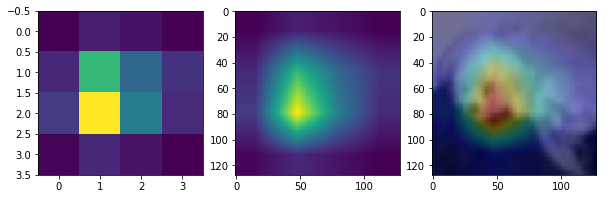

In [19]:
import cv2

fig, axs = plt.subplots(1, 3, figsize=(10,10))

axs[0].imshow(mask)

resized_cam = cv2.resize(mask, (128, 128))

axs[1].imshow(resized_cam)

heatmap = cv2.applyColorMap(np.uint8(255 * resized_cam), cv2.COLORMAP_JET)

img = cv2.imread(img_path)
img = cv2.resize(img, (128,128))
heatimg = heatmap*0.3 + img*0.5
cv2.imwrite('./cam.jpg', heatimg)

cam_img = cv2.imread('./cam.jpg')
cam_img = cv2.cvtColor(cam_img, cv2.COLOR_BGR2RGB)

axs[2].imshow(cam_img)